In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs


In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

path_figure = os.path.join('svg', 'figureS25_weights_comparative_digits_5.svg')

In [3]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
path_figure_layers = os.path.join('svg', 'figure16a_correlation_layers.svg')
path_figure_congruency = os.path.join('svg', 'figure16b_congruency.svg')
path_figure_correlation = os.path.join('svg', 'figure16c_correlation.svg')
path_figure_mds = os.path.join('svg', 'figure16d_mds.svg')
path_figure_dendrogram = os.path.join('svg', 'figure16d_dendrogram.svg')

In [5]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value', 'prime', 'fibonacci', 'multiples3']
idxs_contexts = list(range(len(num_hidden)))

In [6]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_07_17_08)


In [7]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [8]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value', 'prime', 'fibonacci', 'multiples3']


In [9]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0, 0, 0, 0]
value: [0, 1, 0, 0, 0]
prime: [0, 0, 1, 0, 0]
fibonacci: [0, 0, 0, 1, 0]
multiples3: [0, 0, 0, 0, 1]


In [10]:
device = get_device()

num_layers = len(num_hidden)
num_tasks = len(tasks_names)

norm_biases_parity = np.zeros((num_runs, num_layers))
norm_biases_value = np.zeros((num_runs, num_layers))
norm_biases_prime = np.zeros((num_runs, num_layers))
norm_biases_fibonacci = np.zeros((num_runs, num_layers))
norm_biases_mul3 = np.zeros((num_runs, num_layers))

correlations = np.zeros((num_runs, num_layers, num_tasks, num_tasks))

seeds = list(results_task_switching.keys())
for j_seed, seed in enumerate(seeds):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                            num_hidden,
                            idxs_contexts,
                            device)
    model.load_state_dict(state_dict)
    for k_context in idxs_contexts:
        weights = model.layers[k_context].weight.detach().cpu().numpy()

        biases_parity = np.array(weights[:, -5])
        biases_value = np.array(weights[:, -4])
        biases_prime = np.array(weights[:, -3])
        biases_fibonacci = np.array(weights[:, -2])
        biases_mul3 = np.array(weights[:, -1])

        norm_biases_parity[j_seed, k_context] = np.linalg.norm(biases_parity, axis=0)
        norm_biases_value[j_seed, k_context] = np.linalg.norm(biases_value, axis=0)
        norm_biases_prime[j_seed, k_context] = np.linalg.norm(biases_prime, axis=0)
        norm_biases_fibonacci[j_seed, k_context] = np.linalg.norm(biases_fibonacci, axis=0)
        norm_biases_mul3[j_seed, k_context] = np.linalg.norm(biases_mul3, axis=0)

        correlations[j_seed, k_context] = np.corrcoef(weights[:, -num_tasks:], rowvar=False)

Running on CPU.


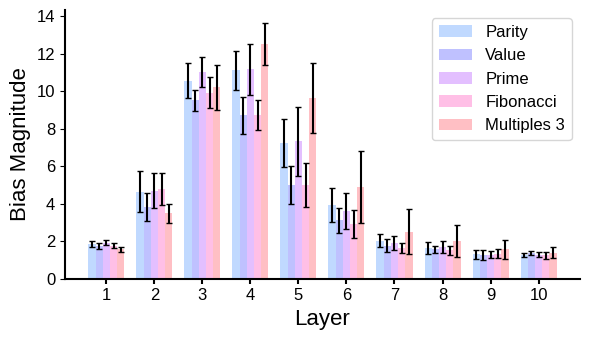

In [14]:
idxs_layers = np.arange(1, 11)

mean_parity = norm_biases_parity.mean(axis=0)
mean_value = norm_biases_value.mean(axis=0)
mean_prime = norm_biases_prime.mean(axis=0)
mean_fibonacci = norm_biases_fibonacci.mean(axis=0)
mean_mul3 = norm_biases_mul3.mean(axis=0)

std_parity = norm_biases_parity.std(axis=0)
std_value = norm_biases_value.std(axis=0)
std_prime = norm_biases_prime.std(axis=0)
std_fibonacci = norm_biases_fibonacci.std(axis=0)
std_mul3 = norm_biases_mul3.std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

width = 0.15
loc = width * np.array([-2, -1, 0, 1, 2])

ax.bar(idxs_layers + loc[0], mean_parity, width=width, color=palette[0], align='center')
ax.bar(idxs_layers + loc[1], mean_value, width=width, color=palette[1], align='center')
ax.bar(idxs_layers + loc[2], mean_prime, width=width, color=palette[2], align='center')
ax.bar(idxs_layers + loc[3], mean_fibonacci, width=width, color=palette[3], align='center')
ax.bar(idxs_layers + loc[4], mean_mul3, width=width, color=palette[4], align='center')

ax.errorbar(idxs_layers+loc[0], mean_parity, std_parity, color='k', linestyle='', capsize=2)
ax.errorbar(idxs_layers+loc[1], mean_value, std_value, color='k', linestyle='', capsize=2)
ax.errorbar(idxs_layers+loc[2], mean_prime, std_prime, color='k', linestyle='', capsize=2)
ax.errorbar(idxs_layers+loc[3], mean_fibonacci, std_fibonacci, color='k', linestyle='', capsize=2)
ax.errorbar(idxs_layers+loc[4], mean_mul3, std_mul3, color='k', linestyle='', capsize=2)

ax.set_xlabel('Layer')
ax.set_ylabel('Bias Magnitude')
ax.set_xticks(idxs_layers)

ax.legend(['Parity', 'Value', 'Prime', 'Fibonacci', 'Multiples 3'])

fig.tight_layout()
fig.savefig(path_figure, transparent=True)

plt.show()